### Setup

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from scipy.signal import convolve2d as conv2, convolve
from tqdm import tqdm
import os
from collections import Counter
import matplotlib.image
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torch import nn
import torch.nn.functional as F

In [2]:
# Mounting data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Model

Define a class that implements the methods needed to train and validate the model.


In [3]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Define the layers of the convolutional neural network extending the base class described above.

In [4]:
class CnnModel(ImageClassificationBase):
  
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
             
             # Convolution & Pool ( queste sono 8 convoluzioni poi unite )
             nn.Conv2d(1, 8, kernel_size=7, stride=1, padding=3),
             nn.ReLU(),
             nn.MaxPool2d(2,2),   # Output: 100 x 100 x 8

             nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
             nn.ReLU(),
             nn.MaxPool2d(2, 2), # Output: 50 x 50 x 16

             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),
             nn.MaxPool2d(2, 2), # Output: 25 x 25 x 32
             
             nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
             nn.ReLU(),    # Output: 25 x 25 x 64

             # Fully-Connected
             nn.Flatten(),
             nn.Linear(64 * 25 * 25, 10240), 
             nn.ReLU(),
             nn.Linear(10240, 1024),
             nn.ReLU(),
             nn.Linear(1024, 512),
             nn.ReLU(),
             nn.Linear(512, 29))

    def forward(self, xb):
        return self.network(xb)

Define a function to train the model and another one to evaluate its performance.

In [5]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, early_stop_limit=3):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in tqdm(range(epochs)):
        losses = []

        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())

        # Validation phase
        result = evaluate(model, val_loader) 

        # Add to results the train loss
        result['train_loss'] = sum(losses) / len(losses)

        model.epoch_end(epoch, result)
        history.append(result)

        # Save model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss':  result['val_loss'],
            }, f'net{epoch}.pt')
        

        # Early stopping implementation
        if len(history) >= early_stop_limit:

          # Delete older models to save space
          os.remove(f'net{epoch-2}.pt')

          # Get last n validation losses
          val_losses = [h['val_loss'] for h in history[-early_stop_limit:]]

          # Return if early stop limit is reached
          if sorted(val_losses) == val_losses:
            return history
      
    return history

### Helper functions

In [6]:
def plot_losses(history):
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history]

    plt.plot(train_losses, '-x', label = "Train Loss")
    plt.plot(val_losses, '-x', label = "Val Loss")

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Losses vs. number of epochs')
    plt.legend()
    plt.show()

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x', label = "Val Accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Accuracy vs. number of epochs')

In [7]:
def get_default_device():
    # Pick GPU if available, else CPU
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    # Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        # Yield a batch of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        # Number of batches
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

### Loading Data

In [8]:
# Steps applied to each image during the loading
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])

# Setting batch size
batch_size = 128

# Load data
dataset = datasets.ImageFolder(r'drive/MyDrive/data/train_selected', transform=transform)

# Get class labels
classes = dataset.classes

# Split train and validation sets
val_size = 580
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(2900, 580)

In [9]:
# Define data loaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

# Assign devide to loaders
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)

### Training the Model

In [ ]:
# Setting: max number of epochs, the optimization function and the learning rate
num_epochs = 100
opt_func = torch.optim.Adam
lr= 0.00001
early_stop_limit = 3

# Setting a seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)

# Instantiate the model
net = CnnModel()
to_device(net, device)

# Training
history = fit(num_epochs, lr, net, train_dl, val_dl, opt_func, early_stop_limit)

  1%|          | 1/100 [00:36<1:00:58, 36.95s/it]

Epoch [0], train_loss: 3.3681, val_loss: 3.3642, val_acc: 0.0416


  2%|▏         | 2/100 [01:13<1:00:01, 36.75s/it]

Epoch [1], train_loss: 3.3558, val_loss: 3.3251, val_acc: 0.0813


  3%|▎         | 3/100 [01:50<59:18, 36.68s/it]  

Epoch [2], train_loss: 3.2147, val_loss: 3.0498, val_acc: 0.1390


  4%|▍         | 4/100 [02:26<58:39, 36.66s/it]

Epoch [3], train_loss: 2.9175, val_loss: 2.7590, val_acc: 0.2111


  5%|▌         | 5/100 [03:03<58:01, 36.64s/it]

Epoch [4], train_loss: 2.6622, val_loss: 2.5035, val_acc: 0.3038


  6%|▌         | 6/100 [03:40<57:23, 36.64s/it]

Epoch [5], train_loss: 2.4382, val_loss: 2.3014, val_acc: 0.3643


  7%|▋         | 7/100 [04:16<56:47, 36.64s/it]

Epoch [6], train_loss: 2.2379, val_loss: 2.1556, val_acc: 0.4209


  8%|▊         | 8/100 [04:53<56:12, 36.66s/it]

Epoch [7], train_loss: 2.0681, val_loss: 1.9431, val_acc: 0.4563


  9%|▉         | 9/100 [05:30<55:36, 36.67s/it]

Epoch [8], train_loss: 1.9094, val_loss: 1.7920, val_acc: 0.5170


 10%|█         | 10/100 [06:06<54:59, 36.66s/it]

Epoch [9], train_loss: 1.7668, val_loss: 1.7065, val_acc: 0.5231


 11%|█         | 11/100 [06:43<54:24, 36.68s/it]

Epoch [10], train_loss: 1.6364, val_loss: 1.5244, val_acc: 0.5860


 12%|█▏        | 12/100 [07:20<53:47, 36.67s/it]

Epoch [11], train_loss: 1.5125, val_loss: 1.4372, val_acc: 0.6150


 13%|█▎        | 13/100 [07:56<53:12, 36.69s/it]

Epoch [12], train_loss: 1.4026, val_loss: 1.3080, val_acc: 0.6468


 14%|█▍        | 14/100 [08:33<52:34, 36.68s/it]

Epoch [13], train_loss: 1.3000, val_loss: 1.2282, val_acc: 0.6710


 15%|█▌        | 15/100 [09:10<51:58, 36.68s/it]

Epoch [14], train_loss: 1.1920, val_loss: 1.1009, val_acc: 0.7299


 16%|█▌        | 16/100 [09:46<51:21, 36.68s/it]

Epoch [15], train_loss: 1.1092, val_loss: 1.0496, val_acc: 0.6960


 17%|█▋        | 17/100 [10:23<50:42, 36.66s/it]

Epoch [16], train_loss: 1.0145, val_loss: 1.0069, val_acc: 0.7332


 18%|█▊        | 18/100 [11:00<50:06, 36.67s/it]

Epoch [17], train_loss: 0.9390, val_loss: 0.8723, val_acc: 0.7611


 19%|█▉        | 19/100 [11:36<49:29, 36.66s/it]

Epoch [18], train_loss: 0.8678, val_loss: 0.7779, val_acc: 0.8022


 20%|██        | 20/100 [12:13<48:53, 36.67s/it]

Epoch [19], train_loss: 0.7870, val_loss: 0.7251, val_acc: 0.8192


 21%|██        | 21/100 [12:50<48:16, 36.67s/it]

Epoch [20], train_loss: 0.7307, val_loss: 0.6486, val_acc: 0.8327


 22%|██▏       | 22/100 [13:26<47:40, 36.67s/it]

Epoch [21], train_loss: 0.6684, val_loss: 0.5849, val_acc: 0.8522


 23%|██▎       | 23/100 [14:03<47:04, 36.68s/it]

Epoch [22], train_loss: 0.6201, val_loss: 0.5619, val_acc: 0.8475


 24%|██▍       | 24/100 [14:40<46:27, 36.68s/it]

Epoch [23], train_loss: 0.5725, val_loss: 0.4656, val_acc: 0.8790


 25%|██▌       | 25/100 [15:16<45:50, 36.67s/it]

Epoch [24], train_loss: 0.5226, val_loss: 0.5123, val_acc: 0.8694


 26%|██▌       | 26/100 [15:53<45:14, 36.68s/it]

Epoch [25], train_loss: 0.4687, val_loss: 0.4336, val_acc: 0.8751


 27%|██▋       | 27/100 [16:30<44:38, 36.69s/it]

Epoch [26], train_loss: 0.4312, val_loss: 0.3597, val_acc: 0.9087


 28%|██▊       | 28/100 [17:06<44:01, 36.69s/it]

Epoch [27], train_loss: 0.4026, val_loss: 0.3435, val_acc: 0.9105


 29%|██▉       | 29/100 [17:43<43:25, 36.70s/it]

Epoch [28], train_loss: 0.3503, val_loss: 0.2996, val_acc: 0.9275


 30%|███       | 30/100 [18:20<42:48, 36.69s/it]

Epoch [29], train_loss: 0.3359, val_loss: 0.2918, val_acc: 0.9046


 31%|███       | 31/100 [18:57<42:11, 36.68s/it]

Epoch [30], train_loss: 0.3021, val_loss: 0.2807, val_acc: 0.9093


 32%|███▏      | 32/100 [19:33<41:33, 36.67s/it]

Epoch [31], train_loss: 0.2797, val_loss: 0.2403, val_acc: 0.9355


 33%|███▎      | 33/100 [20:10<40:56, 36.67s/it]

Epoch [32], train_loss: 0.2705, val_loss: 0.1725, val_acc: 0.9599


 34%|███▍      | 34/100 [20:46<40:19, 36.65s/it]

Epoch [33], train_loss: 0.2339, val_loss: 0.2617, val_acc: 0.9414


 35%|███▌      | 35/100 [21:23<39:43, 36.67s/it]

Epoch [34], train_loss: 0.2133, val_loss: 0.1354, val_acc: 0.9799


 36%|███▌      | 36/100 [22:00<39:06, 36.66s/it]

Epoch [35], train_loss: 0.1938, val_loss: 0.1426, val_acc: 0.9705


 36%|███▌      | 36/100 [22:36<40:12, 37.69s/it]

Epoch [36], train_loss: 0.1688, val_loss: 0.1783, val_acc: 0.9599


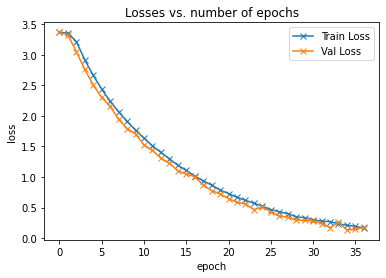

In [ ]:
plot_losses(history)

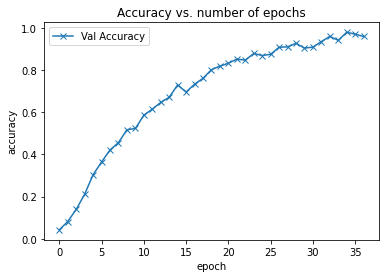

In [ ]:
plot_accuracies(history)

### Testing the Model

Retrive the model from best epoch.

In [ ]:
EPOCH = len(history) - early_stop_limit + 1
PATH = f'net{EPOCH}.pt'

net = CnnModel()
to_device(net, device)

checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['model_state_dict'])

Test the model against all test images.

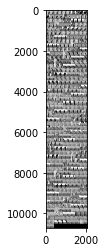

GroundTruth:  A A A A A A A A A A A A A A A A A A B B B B B B B B B B B B B B B B B B C C C C C C C C C C C C C C C C C C D D D D D D D D D D D D D D D D D D E E E E E E E E E E E E E E E E E E F F F F F F F F F F F F F F F F F F G G G G G G G G G G G G G G G G G G H H H H H H H H H H H H H H H H H H I I I I I I I I I I I I I I I I I I J J J J J J J J J J J J J J J J J J K K K K K K K K K K K K K K K K K K L L L L L L L L L L L L L L L L L L M M M M M M M M M M M M M M M M M M N N N N N N N N N N N N N N N N N N O O O O O O O O O O O O O O O O O O P P P P P P P P P P P P P P P P P P Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q Q R R R R R R R R R R R R R R R R R R S S S S S S S S S S S S S S S S S S T T T T T T T T T T T T T T T T T T U U U U U U U U U U U U U U U U U U V V V V V V V V V V V V V V V V V V W W W W W W W W W W W W W W W W W W X X X X X X X X X X X X X X X X X X Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Y Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z Z del del del del del del del del del del del del de

In [ ]:
test_set = datasets.ImageFolder('/content/drive/MyDrive/data/test_selected', transform=transform)
test_loader = DataLoader(test_set, batch_size = 522, num_workers=2, pin_memory=True) 

dataiter = iter(test_loader)
images, labels = next(dataiter)
model = net.cpu()

imshow(torchvision.utils.make_grid(images, nrow=10))

targets = [f'{classes[label]}' for label in labels]
print('GroundTruth: ', ' '.join(targets))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

preds = [f'{classes[pred]}' for pred in predicted]
print('Predicted: ', ' '.join(preds))

accuracy = sum(1 for target, pred in zip(targets, preds) if target == pred) / len(targets) * 100
print(f'Accuracy: {accuracy} %')

Get a detailed report based on previous predictions.

In [ ]:
report = pd.DataFrame()

# Loop for each tested class
for t in sorted(set(targets)):

    # Get indexes from targets for current class
    indexes = [i for i, val in enumerate(targets) if val == t]

    # Get all corresponding predictions
    predicted = [preds[i] for i in indexes]

    # Get the 3 most predicted values for the current class
    counts = Counter(predicted).most_common(3)

    # Calculate percentages and format output
    counts = [f'{pred} : {round(count / len(indexes), 2)}' for pred, count in counts]

    # Fix length of counts if it's less than 3
    counts += [''] * (3 - len(counts))

    # Save to report
    row = pd.DataFrame({'Predicted': counts[0], 'Second Choice': counts[1], 'Third Choice': counts[2]}, index=[t])
    report = pd.concat([report, row])

report

,Predicted,Second Choice,Third Choice
A,A : 0.83,B : 0.06,V : 0.06
B,B : 0.94,Q : 0.06,
C,C : 0.67,I : 0.17,B : 0.11
D,D : 0.89,F : 0.06,T : 0.06
E,E : 0.78,A : 0.06,B : 0.06
F,F : 0.67,E : 0.17,C : 0.06
G,G : 0.89,P : 0.11,
H,H : 0.72,D : 0.17,J : 0.06
I,I : 0.83,H : 0.06,J : 0.06
J,J : 0.83,M : 0.06,V : 0.06
